## Imports

In [1]:
import numpy as np
import pandas as pd

from scipy.optimize import minimize
import scipy.integrate as integrate

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator, MultipleLocator, FormatStrFormatter

import itertools

# matplotlib style sheet
plt.style.use('../style_1.mplstyle')

# INM properties functions (Dutra et al. 2012)

In [2]:
# Constants
fr23, fr53, fr83 = 2./3, 5./3, 8./3
f_pi = (1.5*np.pi**2)**fr23

# Nucleon mass
hbar2_2m = 20.7355


def H(n,y):
    return 2**(n-1.) * (y**n + (1.-y)**n)


def E_ANM(rho, y, parList, BSk_extra=False):
    # Unpack parameter list
    t0, t1, t2, t3, x0, x1, x2, x3, b4, b4p, alpha, amfc, J2terms, t4, t5, x4, x5, delta, gamma = parList
    
    # Convenience parameters
    a = t1*(x1+2.) + t2*(x2+2.)
    b = 0.5 * (t2*(2.*x2 + 1.) - t1*(2.*x1 + 1.))
    
    result = (3./5 * hbar2_2m * f_pi * rho**fr23 * H(fr53,y)
              + t0 / 8. * rho * (2.*(x0+2.) - (2.*x0 + 1.)*H(2.,y))
              + t3 / 48. * rho**(alpha+1.) * (2.*(x3+2.) - (2.*x3 + 1.)*H(2.,y))
              + 3./40 * f_pi * rho**fr53 * (a*H(fr53,y) + b*H(fr83,y)))
    
    if BSk_extra:
        result = (result
                  + 3./40 * f_pi * rho**(fr53+delta) * (t4*(x4+2.)*H(fr53,y) - t4*(x4+0.5)*H(fr83,y))
                  + 3./40 * f_pi * rho**(fr53+gamma) * (t5*(x5+2.)*H(fr53,y) + t5*(x5+0.5)*H(fr83,y)))
    
    return result


def S_SNM(rho, parList, BSk_extra=False):
    # Unpack parameter list
    t0, t1, t2, t3, x0, x1, x2, x3, b4, b4p, alpha, amfc, J2terms, t4, t5, x4, x5, delta, gamma = parList
    
    # Convenience parameters
    a = t1*(x1+2.) + t2*(x2+2.)
    b = 0.5 * (t2*(2.*x2 + 1.) - t1*(2.*x1 + 1.))
    
    result = (hbar2_2m/3. * f_pi * rho**fr23
              - t0/ 8. * (2.*x0 + 1.) * rho
              - t3 / 48. * (2.*x3 + 1.) * rho**(alpha+1.)
              + f_pi/24. * (a + 4.*b) * rho**fr53)
    
    if BSk_extra:
        result = (result
                  - f_pi/8. * t4*x4 * rho**(fr53+delta)
                  + f_pi/24. * t5*(5.*x5 + 4.) * rho**(fr53+gamma))
    
    return result


def L_SNM(rho0, parList, BSk_extra=False):
    # Unpack parameter list
    t0, t1, t2, t3, x0, x1, x2, x3, b4, b4p, alpha, amfc, J2terms, t4, t5, x4, x5, delta, gamma = parList
    
    # Convenience parameters
    a = t1*(x1+2.) + t2*(x2+2.)
    b = 0.5 * (t2*(2.*x2 + 1.) - t1*(2.*x1 + 1.))
    
    result = (fr23*hbar2_2m * f_pi * rho0**fr23
              - 3./8 * t0 * (2.*x0 + 1.) * rho0
              - t3 / 16. * (2.*x3 + 1.) * (alpha+1.)*rho0**(alpha+1.)
              + 5./24 * f_pi * (a + 4.*b) * rho0**fr53)
    
    if BSk_extra:
        result = (result
                  - f_pi/8. * (5. + 3.*delta) * t4*x4 * rho0**(fr53+delta)
                  + f_pi/24. * (5. + 3.*gamma) * t5*(5.*x5 + 4.) * rho0**(fr53+gamma))
    
    return result

## Function to calculate all INM properties

In [3]:
def INM_properties(parList):
    # Check if BSk_gamma is NaN or not
    if np.isnan(parList[-1]):
        BSk_extra = False
    else:
        BSk_extra = True
    
    # Minimise E/rho w.r.t rho, to get rho0 and E0
        # Start guess of 0.16 for rho0, with bounds of (0.13, 0.18)
    e_min_result = minimize(E_ANM, x0=0.16, bounds=[(0.13, 0.18)], args=(0.5, parList, BSk_extra))
    rho0 = e_min_result['x'][0]
    E0 = e_min_result['fun'][0]
    
    # Symmetry energy in SNM
    J = S_SNM(rho0, parList, BSk_extra=BSk_extra)
    
    # Slope of symmetry energy
    L = L_SNM(rho0, parList, BSk_extra=BSk_extra)
    
    return rho0, E0, J, L

# Load data

In [4]:
file_name = '../../ale_utils/skyrme_forces_noReferences.csv'
df = pd.read_csv(file_name, na_values='-', index_col='Skyrme')
df.to_pickle('par_df.pkl')

# Read from Pandas data frame file
df = pd.read_pickle('par_df.pkl')

# Clean data

In [5]:
# Filter out forces with extra parameters
extra_pars = ['t32','t33','t4','x32','x33','x4','alpha2','alpha3','te','to']
df_stand = df[df[extra_pars].isnull().all(1)]

# Remove columns for extra parameters
df_stand = df_stand.drop(extra_pars, axis=1)

# Remove columns with extra information
extra_info_columns = ['exchange', 'cm', 'CHG', 'ipair', 'pairfp', 'pairfn', 'pairfun']
df_stand = df_stand.drop(extra_info_columns, axis=1)

# If b4p is NaN, set equal to b4
df_stand.b4p.fillna(df_stand.b4, inplace=True)

# # Filter out 2-parameter spin-orbit
# df_stand = df_stand[df_stand['b4'] == df_stand['b4p']]

# Problems with INM properties not being calculated properly
df_stand = df_stand.drop(['Ssk', 'SV-kap00'])

# Rename some forces
df_stand = df_stand.rename(index={'QMC600': 'SQMC600',
                                  'QMC650': 'SQMC650',
                                  'QMC700': 'SQMC700',
                                  'QMC750': 'SQMC750',
                                  'SkMs': 'SkM*',
                                  'SKzm1': 'Skz-1',
                                  'BSk17*': 'BSk17',
                                  'BSk18*': 'BSk18'})

# Add NRAPRii with doubled spin-orbit
NRAPRii = df_stand.loc[['NRAPR'],:]
NRAPRii[['b4', 'b4p']] *= 2.
NRAPRii = NRAPRii.rename(index={'NRAPR': 'NRAPRii'})
df_stand = df_stand.append(NRAPRii)

# Fill in J2 terms flag for some forces
df_stand = df_stand.astype({'ls': 'boolean'})
J2forces = ['SLy5',
            'KDE', 'KDE0v', 'KDE0v1',
            'NRAPR', 'NRAPRii',
            'ska25s20', 'ska45s20',
            'SKRA',
            'SGOI', 'SGOII']
df_stand.loc[J2forces,['ls']] = True
noJ2forces = ['BSk15', 'BSk16', 'BSk17', 'BSk18',
              'SQMC600', 'SQMC650', 'SQMC700', 'SQMC750']
df_stand.loc[noJ2forces,['ls']] = False

# Fill in rest of J2 <NA> with False
df_stand.loc[df_stand['ls'].isna(),['ls']] = False

# # No J^2 terms
# df_stand = df_stand[df_stand['ls'] == False]

# Remove rows which are all NaNs
df_stand = df_stand[df_stand.iloc[:,0].notna()]

# Add other forces

In [6]:
# Add extra parameters in BSk forces
extra_pars_BSk = ['BSk_t4', 'BSk_t5', 'BSk_x4', 'BSk_x5', 'BSk_delta', 'BSk_gamma']
df_stand = df_stand.reindex(columns=[*df_stand.columns.tolist(), *extra_pars_BSk], fill_value=np.nan)

df_stand.loc['BSk21'] = [-3961.39, 396.131, 1.e-3, 22588.2,
                         0.885231, 0.0648452, -1390380, 1.03928,
                         54.811, 54.811,
                         1./12,
                         np.nan,
                         False,
                         -100.000, -150.000, 2.00000, -11.0000,
                         0.5, 1./12]

df_stand.loc['BSk24'] = [-3970.28718809175, 395.7662092819614, 1.e-5, 22648.57756432157,
                         0.8943714063887188, 0.05635350781437905, -138961080.022762, 1.051191623994705,
                         54.20264386, 54.20264386,
                         1./12,
                         np.nan,
                         False,
                         -100.000, -150.000, 2.00000, -11.0000,
                         0.5, 1./12]

df_stand.loc['BSk22'] = [-3978.97, 404.461, 1.e-3, 22704.7,
                         0.472558, 0.0627540, -1396130., 0.514386,
                         55.5545, 55.5545,
                         1./12,
                         np.nan,
                         False,
                         -100.000, -150.000, 2.00000, -11.0000,
                         0.5, 1./12]

df_stand.loc['BSk25'] = [-4068.39, 431.093, 1.e-5, 23342.8,
                         1.20467, 0.111366, -138747000., 1.44777,
                         54.3205, 54.3205,
                         1./12,
                         np.nan,
                         False,
                         -200.000, -150.000, 2.00000, -11.0000,
                         0.5, 1./12]

df_stand.loc['BSk26'] = [-4072.53, 439.536, 1.e-5, 23369.1,
                         0.577367, -0.404961, -114770000., 0.624831,
                         55.2545, 55.2545,
                         1./12,
                         np.nan,
                         False,
                         -100.000, -120.000, -3.00000, -11.0000,
                         1./6, 1./12]

# Properties, PNM data, Fortran 90 statements, for a given force

In [10]:
def save_properties(force):
    # Extract list of parameters for 'force'
    parList = df_stand.loc[force].values.tolist()
    
    # Print INM properties
    print(force, INM_properties(parList))

    # Grid of densities
    rho_min = 0.
    rho_max = 1.
    rho_step = 0.001
    rho_grid = np.linspace(rho_min, rho_max, int((rho_max-rho_min)/rho_step) + 1)

    # Check if BSk_gamma is NaN or not
    if np.isnan(parList[-1]):
        BSk_extra = False
    else:
        BSk_extra = True

    # Calculate E/A for PNM
    e_grid = E_ANM(rho_grid, 0., parList, BSk_extra=BSk_extra)
    # Save to file
    np.savetxt('PNM_data/PNM_'+force+'.dat', np.column_stack((rho_grid, e_grid)))
    
    # Calculate E/A for SNM
    eSNM_grid = E_ANM(rho_grid, 0.5, parList, BSk_extra=BSk_extra)
    # Save to file
    np.savetxt('SNM_data/SNM_'+force+'.dat', np.column_stack((rho_grid, eSNM_grid)))
    
    # Calculate S as a function of rho
    s_grid = S_SNM(rho_grid, parList, BSk_extra=BSk_extra)
    # Save to file
    np.savetxt('Esym_data/Esym_'+force+'.dat', np.column_stack((rho_grid, s_grid)))
    
    # Calculate L as a function of rho
    Lrho_grid = L_SNM(rho_grid, parList, BSk_extra=BSk_extra)
    # Save to file
    np.savetxt('Lrho_data/Lrho_'+force+'.dat', np.column_stack((rho_grid, Lrho_grid)))
    
    # Write parameters to file for use in Fortran 90 program
    with open('parameter_sets/pars_'+force+'.f90', 'w') as f:
        # Comment
        f.write('! ' + force + '\n')
        
        # Case statement
        f.write('case()\n')
        
        # force_string
        f.write("    force_string = \'" + force + "\'\n")
        
        # t0-t3, x0-x3
        for i, p in enumerate(parList[:8]):
            f.write('    ' + df_stand.columns[i] + ' = ' + str(p) + '_dp\n')
        
        # Sigma
        f.write('    sigma = ' + str(parList[10]) + '_dp\n')
        
        # W0 is sum of b4 and b4p
        f.write('    W0 = ' + str(sum(parList[8:10])) + '_dp\n')
        
        # hbar^2/2m
        f.write('    hbar2_2m_q(:) = 20.73553_dp\n\n')
    
    return np.column_stack((rho_grid, e_grid))

"""
IMPORTANT: check parameters are correct in corresponding paper,
and verify the INM properties, before using in code
"""
# List of forces for which to print and save properties
forceList = ['BSk22',
             'BSk24',
             'LNS',
             'SQMC650',
             'SQMC700',
             'SII',
             'SIV',
             'SKa',
             'SkM*',
             'Skz-1',
             'SLy4',
             'KDE',
             'KDE0v1',
             'NRAPRii',
             'SKRA']
# forceList = ['BSk21', 'BSk22', 'BSk24', 'BSk25', 'BSk26']
# forceList = ['BSk13', 'BSk14', 'SQMC650']
# allForces = list(df_stand.index.values)
# BSk = [i for i in allForces if 'BSk' in i]
# forceList = BSk# + ['LNS', 'NRAPR', 'SKRA', 'SQMC700']
# forceList = sorted(forceList)

PNM_data = []

for force in forceList:
    PNM_data.append(save_properties(force))

BSk22 (0.15783873952820907, -16.087466307095063, 31.99944321115617, 68.48515784449046)
BSk24 (0.15784186782027926, -16.048360240836367, 29.99999220262265, 46.39664533433756)
LNS (0.17455589682351863, -15.314271149422986, 33.42597973213489, 61.45492986182979)
SQMC650 (0.17196635273340052, -15.572820400560978, 33.652762143141004, 52.92447310166046)
SQMC700 (0.17041627101413712, -15.490207368919087, 33.40297011786971, 59.01465195308195)
SII (0.1481683924678738, -15.95975412870105, 34.13744243649163, 50.073878281458946)
SIV (0.15092759402737219, -15.959222162951654, 31.218683754460766, 63.49690111327541)
SKa (0.15534722815573618, -15.991022610119296, 32.910110792804524, 74.62259829910414)
SkM* (0.1602924712657349, -15.770371608637255, 30.033171759272392, 45.7779252941984)
Skz-1 (0.16001872963967861, -16.00523524819688, 32.00229516632299, 54.14482463855995)
SLy4 (0.15953890386099306, -15.972187254685855, 32.000863269414474, 45.94451791568263)
KDE (0.16436934385233407, -15.992989440424282, 3

# PNM curves for chosen forces

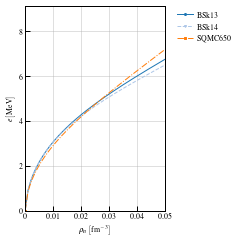

In [498]:
APR = np.loadtxt('apr_pnm.dat')
APR2 = np.loadtxt('apr_pnm2.dat')
LS2 = np.loadtxt('ls2_pnm.dat')

fig, ax = plt.subplots(figsize=(3.4, 3.4))

# Colours, lines, and markers for plot
lines = itertools.cycle(['-', '--', '-.', ':'])
markers = itertools.cycle(['o', 'v', 's', 'D'])
cmap = plt.cm.get_cmap('tab20')
colours = cmap.colors
ax.set_prop_cycle(color=colours)

# Plot lines
for i, (data, force, l, m) in enumerate(zip(PNM_data, forceList, lines, markers)):
    ax.plot(data[:,0], data[:,1], label=force, ls=l, lw=1., 
            marker=m, markevery=100, ms=2.)

# # Microscopic calculations as points on main plot
#     # APR
# ax.plot(APR[:,0], APR[:,1], marker="^", linestyle='None', color='b', label='APR')
# ax.plot(APR2[:,0], APR2[:,1], marker="x", linestyle='None', color='b', label='APR2')
#     # LS2
# LS2x = np.linspace(0.001, 0.5, 5)
# LS2y = 55.9*LS2x + 532.3*(LS2x**2.68)
# ax.plot(LS2x, LS2y, marker="x", linestyle='None', color='r', label='LS22')
# ax.plot(LS2[:,0], LS2[:,1], marker="o", linestyle='None', color='r', label='LS2')

ax.set_xlim([0., 0.05])
ax.set_ylim([0., 9.1])

ax.set_xlabel(r'$\rho_n \left[\mathrm{fm}^{-3}\right]$')
ax.set_ylabel(r'$e \left[\mathrm{MeV}\right]$')

# Ticks and grid
# ax.xaxis.set_major_locator(MultipleLocator(0.01))
# ax.xaxis.set_minor_locator(MultipleLocator(0.005))
# ax.yaxis.set_minor_locator(MultipleLocator(1.))
ax.xaxis.set_major_formatter(FormatStrFormatter('%g')) # No unnecessary trailing decimals
# ax.grid(True, which='both')

# ax.legend(loc='upper left', ncol=2, handlelength=4.)
ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

fig.tight_layout()
fig.savefig('PNM_comparison.pdf')

# Calculate INM properties for all forces

In [499]:
# New column with all INM properties in one tuple on each row
df_stand['inm_tuple'] = df_stand.iloc[:,:].apply(INM_properties, axis=1)

# Unpack tuple to four separate columns
INM_strings = ['rho0', 'E0', 'J', 'L']
df_stand[INM_strings] = pd.DataFrame(df_stand['inm_tuple'].tolist(), index=df_stand.index)

# Delete tuple column
df_stand = df_stand.drop(['inm_tuple'], axis=1)

# Surface energy $a_{surf}^{MTF}$

In [500]:
# a_{surf}^{MTF} (Jodon et al., using notation in this reference for variables)
def a_surf_MTF(parList):
    if (parList[12] != True) & (parList[12] != False):
        return
    
    rho_sat = parList[19]
    r0 = (3./(4.*np.pi*rho_sat))**(1./3)
    
    def integrand(rho_0, rho_sat, parList):
        # Unpack parameter list
        (t0, t1, t2, t3,
         x0, x1, x2, x3,
         b4, b4p, alpha, amfc, J2terms,
         t4, t5, x4, x5, delta, gamma,
         rho_sat, E0, J, L) = parList
        
        C_0_tau = 3./16*t1 + 0.25*t2*(1.25+x2)
        C_0_d2rho = -9./64*t1 + 1./16*t2*(1.25+x2)
        d = (1./18 - 1./3) * C_0_tau - C_0_d2rho
        
        C_0_dJ = -1.*b4 - 0.5*b4p
        C_0_J = 0.#J2terms * (0.125*t1*(0.5-x1) - 0.125*t2*(0.5+x2))
        Q = hbar2_2m + C_0_tau*rho_0 + C_0_J*rho_0
        V_so = -0.5 * C_0_dJ**2 / Q
        
        hs = hbar2_2m/18. + d*rho_0 + V_so*rho_0**2
        return np.sqrt(hs * (E_ANM(rho_0, 0.5, parList[:19]) - E_ANM(rho_sat, 0.5, parList[:19])))
    
    integral, err = integrate.quad(integrand, 0, rho_sat, args=(rho_sat, parList))
                       
    return 8.*np.pi*r0**2 * integral

parColumns = df_stand.columns.tolist()
# df_stand = df_stand.drop(['a_surf_MTF'], axis=1)
df_stand['a_surf_MTF'] = df_stand.loc[['SkM*', 'LNS', 'SKa', 'SKRA', 'NRAPRii', 'Skz-1', 'SLy4',
                                       'KDE', 'KDE0v1',
                                       'SQMC650', 'SQMC700',
                                       'SII', 'SIV'],
                                       parColumns].apply(a_surf_MTF, axis=1)

# Filter forces

In [513]:
# Reasonable values of J
# df_stand = df_stand[(df_stand['J'] > 30.) & (df_stand['J'] < 35.)]
# df_stand = df_stand[(df_stand['L'] > 40.) & (df_stand['L'] < 76.)]

# Save data frame with "reasonable" forces
df_stand.to_pickle('forcesINMproperties.pkl')

In [503]:
df_stand.nsmallest(10, 'rho0')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
QMC1,0.137349,-14.003146,29.682471,-6.698538
QMC2,0.140261,-14.285024,28.697387,8.674790
SVII,0.143379,-15.788860,26.960131,-10.158341
SVI,0.143491,-15.754635,26.884068,-7.332653
SIII,0.145268,-15.851361,28.161979,9.911084
SkT,0.147601,-15.403419,24.891200,28.237670
SII,0.148168,-15.959754,34.137442,50.073878
SIIIs,0.150691,-16.567714,32.661591,29.295944
SIV,0.150928,-15.959222,31.218684,63.496901


In [504]:
df_stand.nlargest(10, 'rho0')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
LNS,0.174556,-15.314271,33.425980,61.454930
SQMC600,0.173584,-15.733760,34.377802,46.386739
SQMC650,0.171966,-15.572820,33.652762,52.924473
SQMC750,0.170999,-15.598704,33.746939,64.672143
SQMC700,0.170416,-15.490207,33.402970,59.014652
SkTK,0.168114,-16.695111,35.567694,41.589070
SGOII,0.168114,-16.695064,93.975831,246.017717
SGOI,0.167800,-16.629356,45.195345,99.763858
KDE0v1,0.164578,-16.231048,34.582519,54.695255


In [505]:
df_stand.nsmallest(10, 'E0')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
SkTK,0.168114,-16.695111,35.567694,41.589070
SGOII,0.168114,-16.695064,93.975831,246.017717
SGOI,0.167800,-16.629356,45.195345,99.763858
SIIIs,0.150691,-16.567714,32.661591,29.295944
SK255,0.157253,-16.331256,37.395399,95.052404
SK272,0.155327,-16.277213,37.395302,91.666435
KDE0v1,0.164578,-16.231048,34.582519,54.695255
ska35s25,0.157643,-16.135214,36.980630,98.885715
E,0.159143,-16.125291,27.659875,-31.262259


In [506]:
df_stand.nlargest(10, 'E0')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
QMC1,0.137349,-14.003146,29.682471,-6.698538
QMC2,0.140261,-14.285024,28.697387,8.674790
LNS,0.174556,-15.314271,33.425980,61.454930
Sefm1,0.161055,-15.402476,24.811646,59.548319
SkT,0.147601,-15.403419,24.891200,28.237670
SQMC700,0.170416,-15.490207,33.402970,59.014652
Sefm09,0.160895,-15.551133,27.780687,69.959216
SkMP,0.157036,-15.560373,29.885273,70.308620
SQMC650,0.171966,-15.572820,33.652762,52.924473


In [507]:
df_stand.nsmallest(10, 'J')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
SkSC10,0.160715,-15.960480,22.826515,19.129241
SKb,0.155347,-15.991023,23.884316,47.545215
SkSC6,0.160718,-15.920916,24.574548,11.000217
SkSC2,0.160643,-15.899294,24.737317,11.000272
Sefm1,0.161055,-15.402476,24.811646,59.548319
SkT,0.147601,-15.403419,24.891200,28.237670
SkM1,0.160292,-15.770372,25.171759,-35.363037
Es,0.162755,-16.017124,26.440545,-36.851827
Zs,0.162981,-15.876257,26.692275,-29.373999


In [508]:
df_stand.nlargest(10, 'J')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
SGOII,0.168114,-16.695064,93.975831,246.017717
Sefm068,0.160181,-15.922869,88.563997,254.420903
QMC3,0.160720,-15.982829,45.778392,91.800574
SGOI,0.167800,-16.629356,45.195345,99.763858
SkI1,0.160364,-15.951238,37.521358,161.024493
SK255,0.157253,-16.331256,37.395399,95.052404
SK272,0.155327,-16.277213,37.395302,91.666435
SkT5,0.164002,-15.997131,37.004416,98.527347
SkT5a,0.164002,-15.997131,37.004416,98.527347


In [509]:
df_stand.nsmallest(10, 'L')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
Z,0.158945,-15.972002,26.823284,-49.692877
Es,0.162755,-16.017124,26.440545,-36.851827
SkM1,0.160292,-15.770372,25.171759,-35.363037
E,0.159143,-16.125291,27.659875,-31.262259
Zs,0.162981,-15.876257,26.692275,-29.373999
SVII,0.143379,-15.788860,26.960131,-10.158341
SkSC4o,0.160592,-15.844496,26.984578,-9.621344
SVI,0.143491,-15.754635,26.884068,-7.332653
SkSC5,0.160638,-15.846354,30.987787,-6.959578


In [510]:
df_stand.nlargest(10, 'L')[INM_strings]

,rho0,E0,J,L
Skyrme,,,,
Sefm068,0.160181,-15.922869,88.563997,254.420903
SGOII,0.168114,-16.695064,93.975831,246.017717
SkI1,0.160364,-15.951238,37.521358,161.024493
SkI5,0.155756,-15.845832,36.642144,129.321754
SkI2,0.157530,-15.774927,33.374300,104.332344
SkI3,0.157729,-15.979876,34.833313,100.522974
SGOI,0.167800,-16.629356,45.195345,99.763858
ska35s25,0.157643,-16.135214,36.980630,98.885715
SkT5,0.164002,-15.997131,37.004416,98.527347


In [511]:
df_stand['amfc']

Skyrme
BSk1     20.73553
BSk2     20.73553
BSk2p    20.73553
BSk3     20.73553
BSk4     20.73553
           ...   
BSk21         NaN
BSk24         NaN
BSk22         NaN
BSk25         NaN
BSk26         NaN
Name: amfc, Length: 204, dtype: float64

# Histogram of variation of properties

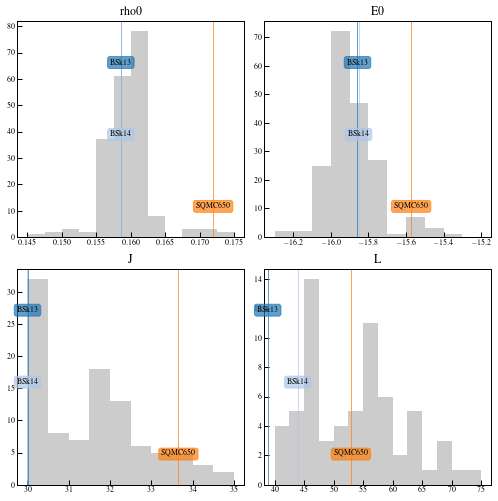

In [512]:
# Histogram of INM properties
fig, axs = plt.subplots(2, 2, figsize=(7., 7.))

# Bin edges
bins = [np.arange(0.145, 0.1775, 0.0025),
        np.arange(-16.3, -15.2, 0.1),
        np.arange(30., 35.5, 0.5),
        np.arange(40., 77.5, 2.5)]

for i, ax in enumerate(fig.axes):
#     df_stand.hist(column=INM_strings[i], grid=False, ax=ax, alpha=0.2, color='k', bins=10)
    df_stand.hist(column=INM_strings[i], grid=False, ax=ax, alpha=0.2, color='k', bins=bins[i])
    
#     ax.set_ylim([0., 23.])
#     ax.yaxis.set_major_locator(MultipleLocator(base=2))
    
    for j, (force, colour) in enumerate(zip(forceList, colours)):
        # Vertical line for each highlighted force
        ax.axvline(x=df_stand.loc[force].at[INM_strings[i]], color=colour, linewidth=0.7)
        
        # Text box for each force
        ax.annotate(force,
                    xy=(df_stand.loc[force].at[INM_strings[i]],
                        ax.get_ylim()[1] * (len(forceList)-j-0.6) / len(forceList)),
                    ha='center',
                    bbox=dict(boxstyle='round',
                              facecolor=colour,
                              edgecolor=colour,
                              alpha=0.7))

fig.tight_layout()
fig.savefig('histogram.pdf')